In [1]:
import numpy as np
import cv2 as cv
import os, sys, glob, scipy, argparse
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fftpack, fft
from scipy.fftpack import fftshift, irfft, rfft 
from scipy.signal import blackman

In [109]:
class CrossHatch(object):
    """generate plots and pass/fail outputs based on frequency vs. distance
    INPUTS: 
         1) path: the path that contains all the images
    OUTPUT options:
      1) createDict
      returns: hashtable w/ dictionary key: what # the image is in the dir, 
      BUT LATER PLEASE DONT FORGET TO replace with serial number
         dict values: 
            a) original image 
            b) brg2grey, Scharr edge detection (2d conv), LPF, threshold
            c) y-sobel
            d) fitted contours of minimum enclosing area
            e) plot of FFT score vs. column number
      2) subPlotsLong: 646 subplots for long, or 
      3) subPlotsShort: 484 subplots for short crosshatch
      BUT LATER PLEASE REPLACE FFT WITH DCT"""
    def __init__(self, path , rows, col):
        assert os.path.isdir(pathTest), "hey"
        self.path = path
        self.rows = rows
        self.col = col
    def createDict(self):
        # define scharr kernal to convolve along diagonals
        kern = [[0, 1,  0], [1, 0, -1],[ 0, -1 ,0]]
        # define counter to number how many images in the dir
        count = 1
        white = {}
        img = [] # 1st value in dictionary
        imgScharr = [] # 2nd value in dictionary
        score = [] # will be used as numerical value > 0 that quantifies how many cols are crosshatched
        print("Image directory: " + str(self.path))
        print("Number of rows: " + str(self.rows))
        print("Number of col: " + str(self.col))
        for fname in glob.glob(self.path+'/*.Png'):
            #print(fname)
            img.append(cv.imread(fname)) #first value pair
            plt.figure()
            plt.title('White Image ' + str(count) + ": flipped from RGB --> BGR")
            plt.imshow(img[-1])
            #==============================================================
            # 1st VALUE, original pixel BGR mat 
            #==============================================================
            im = img.copy()
            imgray = cv.cvtColor(im[-1], cv.COLOR_BGR2GRAY)

            #==============================================================
            # 2nd VALUE, Scharr pixel mat
            #==============================================================
            imgray = cv.bilateralFilter(imgray, 15, 75, 75)
            ret, thresh = cv.threshold(imgray, 10, 255, cv.THRESH_BINARY)
            contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            im_with_contours = cv.drawContours(im[-1], contours, -1, (0,255,0), 6)
            diag_img = signal.convolve2d(imgray, np.array(kern), boundary='symm', mode='same')
            imgScharr.append(diag_img) #2nd value pair
            #plt.figure()
            #plt.title('White Image ' + str(count) + ": Scharr operator + LPF")
            #plt.imshow(diag_img+101, cmap="gray")
            #plt.imshow(diag_img , cmap="gray")
            #plt.show()
            
            
            #================================================================
            # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html
            # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html
            # ^sobelx vs. sobely, we see that sobely will perform better 
            # https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html
            # https://stackoverflow.com/questions/54950777/opencv-drawing-contours-with-various-methods-on-a-poor-image
            #================================================================
            plt.figure()
            diag_cpy = (((diag_img.copy()+2))/4*255).astype(np.uint8) #bc min=-2 and max=+2


            print('max = {}, min = {}'.format(np.max(diag_cpy), np.min(diag_cpy)))
            print(' diag shape = ',diag_cpy.shape)
            edged = cv.Canny(diag_cpy, 160, 230)
            #plt.figure()
            #plt.imshow(edged, cmap="gray")
            #plt.show()
            
            sobelx = cv.Sobel(diag_cpy,cv.CV_64F,1,0,ksize=5)  
            sobely = cv.Sobel(diag_cpy,cv.CV_64F,0,1,ksize=5)
            print('sobel max = {}, min = {}'.format(np.max(sobely), np.min(sobely)))

            #plt.figure()
            #plt.imshow(sobelx)
            #plt.show()
            #plt.figure()
            #plt.imshow(sobely)
            #plt.show()
            cnts,_ = cv.findContours(edged.copy()[:,:50], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
            print('contours shape {}'.format(np.array(cnts).shape))
            backtorgb = cv.cvtColor(diag_cpy,cv.COLOR_GRAY2RGB)
            cv.drawContours(backtorgb, cnts, -1, (0, 255, 0), 2)
            
            plt.imshow(backtorgb)
            plt.title('Edged Contours, Scharr -> canny')
            plt.show()
        
            
            #====================================================================================================
            # 3rd VALUE, 4 subplots: 1st) spatial domain BGR, 2) plot np.fft.fft, 3) stem fftpack.fftfreq
            #====================================================================================================
            samplingFreq = 100
            samplingInterval = 1 / samplingFreq
            beginTime = 0
            endTime = self.col
            teim = np.arange(beginTime,endTime, 1)
            countPeaks = [] # max valu = 646, counts how many stem peaks there are per column
            
            for i in range(self.col):
                #figure , axis = plt.subplots(3,1)
                freqRowSamps = np.linspace(0,self.rows-1, self.rows)
                # the issue is x-axis png ranges from 481, y-axis ranges 646, but these values change slightly based on image
                amplitude = imgray[:,i] # ampltiude == # of rows
                
                
                #print("--------------------------------------------------------")
                #plt.subplots_adjust ( hspace = 3)
                #time domain representation for CrossHatch periodic signal
                #axis[0].set_title('White Image #%s' % (count) +', Col #%s' % (i) + " Spatial Intensity vs. Pixel distance" )
                #axis[0].set_xlabel('Pixel Distance along y-axis ')
                #axis[0].set_ylabel('Pixel intensity')
                #axis[0].plot(amplitude)
                
                """
                # https://pythontic.com/visualization/signals/fouriertransform_fft
                plt.subplots_adjust ( hspace = 3)
                # frequency domain representation
                fourierTransf = np.fft.fft(amplitude)/ len(amplitude) # normalize amplitude
                fourierTransf = fourierTransf[range(int(len(amplitude)/2))] #exclude sampling freq??
                tpCount = len(amplitude)
                val = np.arange(int(tpCount/2))
                timePer = tpCount/samplingFreq
                freq = val/timePer 
                axis[1].set_title('White Image # %s' % (count) +', Col # %s' % (i) + " FFT Intensity vs. Pixel distance fft.fft plot " )
                axis[1].set_xlabel('Frequency along y-axis pixel locations')
                axis[1].set_ylabel('Amplitude')
                axis[1].plot(freq, abs(fourierTransf))
                # https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/fftpack.html
                # Windowing the signal with a dedicated window function helps mitigate spectral leakage.
                # a Blackman window from scipy.signal and shows the effect of windowing
                # try irfft, rfft, fftshift?
                plt.subplots_adjust ( hspace = 3)
                yf = fft(amplitude)
                w = blackman(self.rows)
                ywf = irfft(w*yf)
                axis[3].set_title('White Image # %s' % (count) +', Col # %s' % (i) + " FFT Intensity vs. Pixel distance fft.fft semilogy" )
                axis[3].set_xlabel('Frequency along y-axis pixel locations')
                axis[3].set_ylabel('Amplitude')
                #axis[3].set_xlim(-samplingFreq / 2, samplingFreq / 2)
                #axis[3].set_ylim(-2, 100000)
                axis[3].semilogy(frequen, np.abs(ywf))
                print("--------------------------------------------------------")
                """
                
                # https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
                #plt.subplots_adjust ( hspace = 3)
                X = fftpack.fft(amplitude)
                amplitude1 = fftpack.fftfreq(len(amplitude))*samplingFreq
                #axis[1].set_title('Image #%s' % (count) +', Col #%s' % (i) + " FFT Intensity vs. Pixel distance (fftpack.fftfreq) stem " )
                #axis[1].set_xlabel('Frequency along y-axis pixel locations')
                #axis[1].set_ylabel('Amplitude')
                #axis[1].set_xlim(-5, samplingFreq / 1.2)
                #axis[1].set_ylim(-2, 600)
                #print(max(np.abs(X))) 
                #axis[1].stem(freqRowSamps, np.abs(X), use_line_collection = True) 
                
                #plt.subplots_adjust ( hspace = 3)     
                # https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/
                #freqPeaks = scipy.signal.find_peaks( np.abs(X) , height=[200, 1000000] )
                freqPeaks = scipy.signal.find_peaks( np.abs(X) , height=[200, 800] )
                indexPeaks = freqPeaks[0]
                heightPeaks = np.array(list(freqPeaks[1].values()) , dtype = object)
                heightPeaks = heightPeaks[0]
                #print('height peaks: ' + str(heightPeaks))
                #print('index peaks: ' + str(indexPeaks))
                #axis[2].set_title('Image #%s' % (count) +', Col #%s' % (i) + " Peaks")
                #axis[2].set_ylabel('Amplitude')
                #axis[2].set_xlabel('Frequency along y-axis pixel locations')
                #axis[2].set_xlim(-5, samplingFreq / 1.2)
                #axis[2].set_ylim(-2, 600)
                if heightPeaks.size > 0:
                    #axis[2].stem(indexPeaks,heightPeaks, use_line_collection=True)
                    countPeaks.append(len(heightPeaks))
                else:
                    countPeaks.append(0)
            
            print('length crosshatch is ' + str(len(countPeaks)))
            isCrossHatch = sum(countPeaks)
            score.append(isCrossHatch)
            plt.figure()
            plt.plot(countPeaks,'bo')
            plt.title("Number of peaks in FFT spectrum vs. Column location")
            plt.xlabel("Column #")
            plt.ylabel("Number of peaks")
            plt.show()
            
            #print( " img[count-1]" , img[count-1])
            #print("imgScharr[count-1]," ,imgScharr[count-1])
            #print("score[count-1])" ,score)
            #print("score[count-1])" ,score[count-1])
            white.update( { 'white %s' % (count): (img[count-1]  , imgScharr[count-1], score[count-1])  } )

            count = count +1

Image directory: /Users/estepark/Documents/week1_thurs/GRR_Sample/Vermouth_EVT/20181126/Images/Reg/White
Number of rows: 646
Number of col: 480
max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 7414.0, min = -6887.0
contours shape (1197,)


/Users/estepark/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


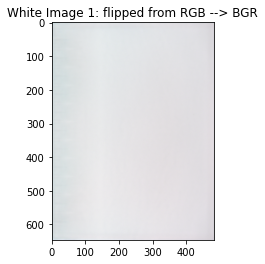

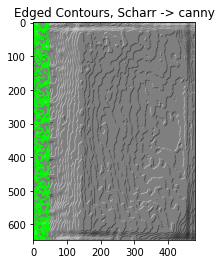

length crosshatch is 480


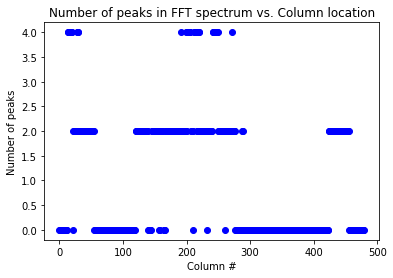

max = 255, min = 0
 diag shape =  (645, 480)
sobel max = 6565.0, min = -6832.0
contours shape (1150,)


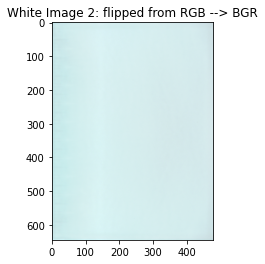

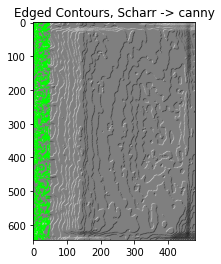

length crosshatch is 480


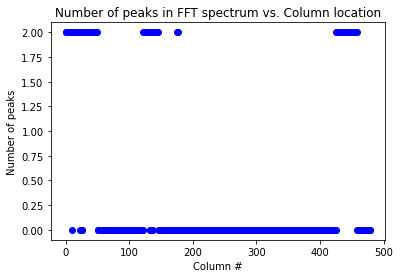

max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 7468.0, min = -6580.0
contours shape (1251,)


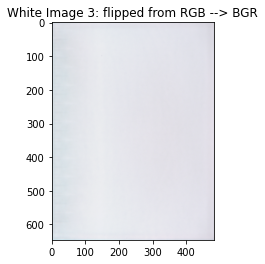

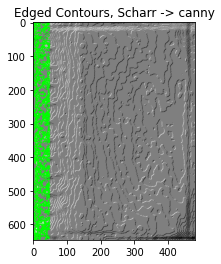

length crosshatch is 480


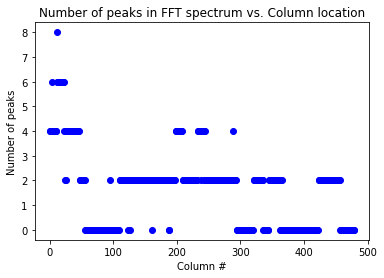

max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 7334.0, min = -6968.0
contours shape (1117,)


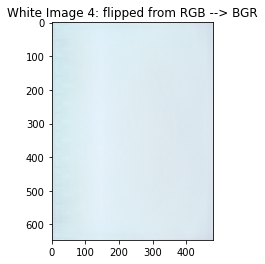

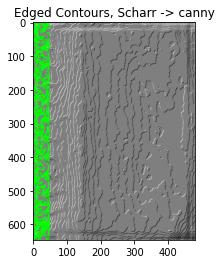

length crosshatch is 480


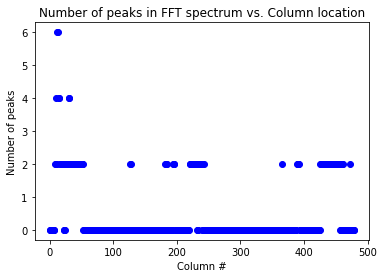

max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 6582.0, min = -7291.0
contours shape (1158,)


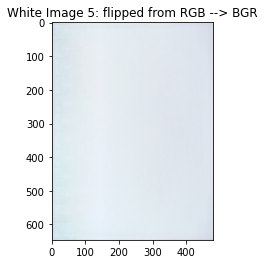

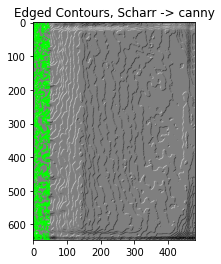

length crosshatch is 480


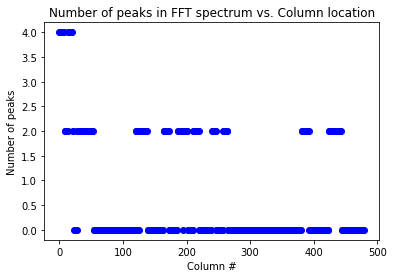

max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 6200.0, min = -6646.0
contours shape (1303,)


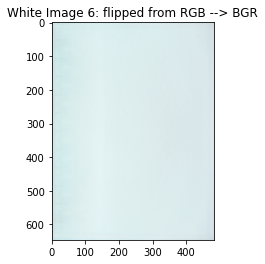

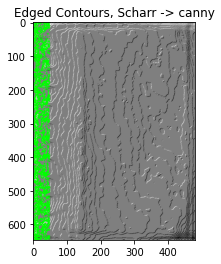

length crosshatch is 480


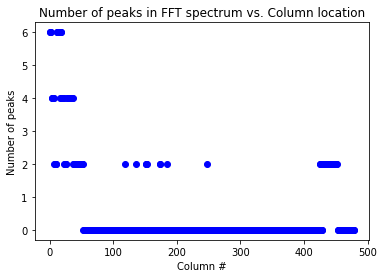

max = 255, min = 0
 diag shape =  (645, 480)
sobel max = 7528.0, min = -7976.0
contours shape (1295,)


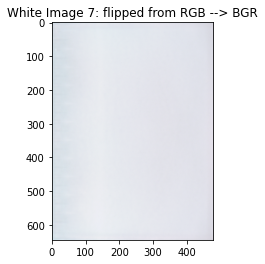

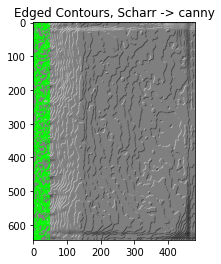

length crosshatch is 480


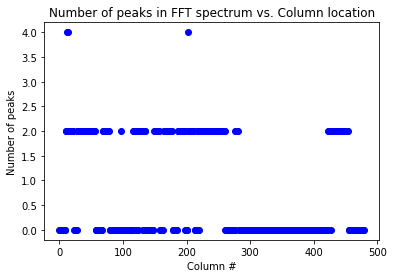

max = 255, min = 0
 diag shape =  (645, 480)
sobel max = 7527.0, min = -7084.0
contours shape (1199,)


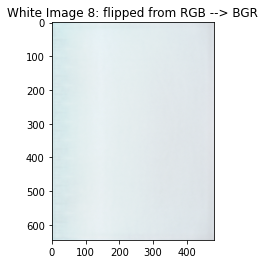

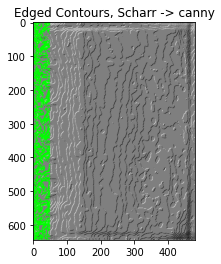

length crosshatch is 480


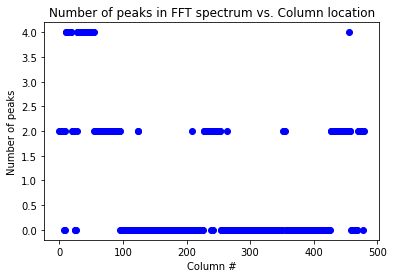

max = 255, min = 0
 diag shape =  (645, 480)
sobel max = 6976.0, min = -7083.0
contours shape (1044,)


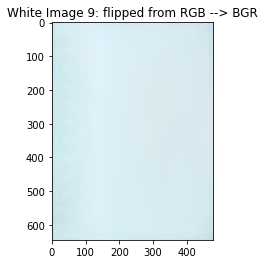

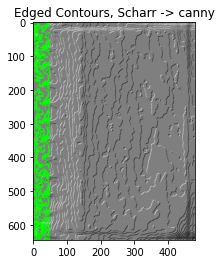

length crosshatch is 480


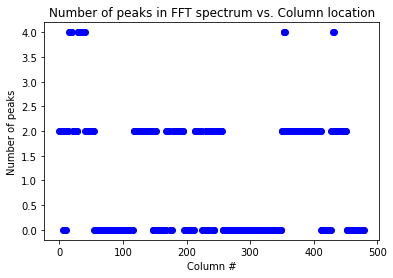

max = 255, min = 0
 diag shape =  (646, 481)
sobel max = 7214.0, min = -7027.0
contours shape (1268,)


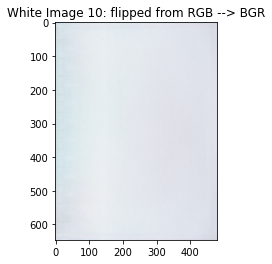

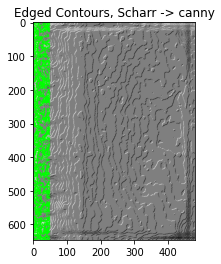

length crosshatch is 480


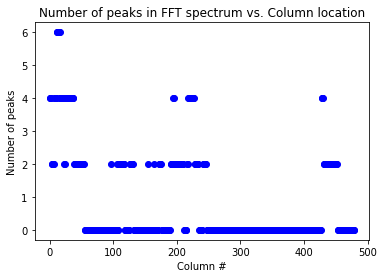

In [110]:
pathTest = '/Users/estepark/Documents/week1_thurs/GRR_Sample/Vermouth_EVT/20181126/Images/Reg/White'
isdir = os.path.isdir(pathTest) 

stuff = CrossHatch(path = pathTest, rows=  646, col= 480)
stuff.createDict()

In [ ]:
white = {}
 white.update( { 'white %s' % (count): (img[count-1]  , imgScharr[count-1], score[count-1])  } )
    
len(img)
count = 1
"""
objective: 
1) iterate through every 600 columns, find greatest variation in peaks

2) rank the greatest peak variations
"""
White = {}
for i in range(10):
    #print(count)
    White.update( { 'white %s' % (count): (img[i]  , imgScharr[i]) } )
    count = count +1 
    #print(White)

index is [2 6]
dict_keys(['peak_heights'])
heights is [[150. 150.]]
1


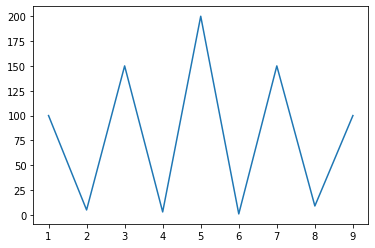

In [95]:
import scipy
amplitude1 = [100,5,150,3,200,1,150,9,100] 
time = [1,2,3,4,5,6,7,8,9]
plt.plot(time,amplitude1)
a=scipy.signal.find_peaks(amplitude1,height=[125,175 ]  )
print("index is " + str(a[0]))
print(a[1].keys())
heights = np.array(list(a[1].values() ), dtype = float)
#heights = heights[0]
print("heights is " +str(heights))
print(len( heights  ))

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
from collections import defaultdict
from scipy import signal
import matplotlib.pyplot as plt
from math import pi
import os, scipy, glob
from scipy import fftpack, fft
from scipy.fftpack import fftshift, irfft, rfft 
from scipy.signal import blackman

get_ipython().magic('matplotlib inline')
fname = '1_20200611_152306_White_Reg.csv'
#x1 = pd.read_csv(fname)
gname = '/Users/estepark/Documents/week6_fri/Data/1_20200611_152306_White_Reg.csv'
Lv_csv = pd.read_csv(fname, skiprows=[0,*range(1362,4085)], header=None)

#Lv_csv = pd.read_csv(fname, skiprows=[0,*range(1294,3881)], header=None)
u_csv = pd.read_csv(fname, skiprows=[*range(0,1363), *range(2724,4085)], header=None)

#u_csv = pd.read_csv(fname, skiprows=[*range(0,1295), *range(2588,3882)], header=None)
v_csv = pd.read_csv(fname, skiprows=[*range(0,2725)], header=None)

#v_csv = pd.read_csv(fname, skiprows=[*range(0,2588)], header=None)
# u' = 1362
# v' = 2725
"""
author: ester park, estepark@amazon.com
steps:
1) first take Lv values and imshow
2) determine if it's circle, short-crosshatch, or long-crosshatch
3) find fft of the circle in deg/rad vs. radius
"""
class Crosshatch(object):
    def __init__(self,x1): 
        assert isinstance(x1, pd.core.frame.DataFrame)
        #assert 'Lv' in x1
        self.x1 = x1
    def detect(self):
        pass
Lv = Crosshatch(Lv_csv)
u = Crosshatch(u_csv)
v = Crosshatch(v_csv)
#mode.detect()

In [ ]:
"""
INPUT == Short cross hatches
FN == Short cross hatch search
OUTPUT == # FFT PEAKS VS. # COLS (POS CORRELATION)
"""
plt.figure()
imgLv = np.array(Lv.x1, dtype = "uint8") #cv2 for 8u and 32f images in function 'bilateralFilter'
imgLvcopy = imgLv.copy()
plt.imshow(np.array(Lv.x1), cmap="gray")

#cv.imread(Lv.x1)
plt.title('Lv from csv file converted to image')
#plt.show()

# provide Scharr kernel
kern = [[0, 1,  0], [1, 0, -1],[ 0, -1 ,0]]
imgrayLv = cv.bilateralFilter(imgLv, 20, 75, 75)
diag_imgLv= signal.convolve2d(imgrayLv, np.array(kern) , boundary ='symm', mode='same')
plt.figure()
plt.imshow(diag_imgLv, cmap = "gray")
plt.title("Scharr + LPF ")
plt.show()

# scale back to [0,255], becuase convolve2d changes ranges [-2,+2]
diag_cpy = (((diag_imgLv.copy()+2))/4*255).astype(np.uint8) #bc min=-2 and max=+2
#print('max = {}, min = {}'.format(np.max(diag_cpy), np.min(diag_cpy)))  #confirm min/max
#print(' diag shape = ',diag_cpy.shape) 
edged = cv.Canny(diag_cpy, 160, 230)

#sobelx = cv.Sobel(diag_cpy,cv.CV_64F,0,1,ksize=5)
#plt.figure()
#plt.imshow(diag_cpy)
#plt.title('diag_cpy scaled to 0,255')
#plt.show()
#==================================================
# perform short crosshatch # FFT scores vs. # row slice, around row #1200 should see period 
#==================================================
samplingFreq = 100
samplingInterval = 1 / samplingFreq
beginTime = 0
print(imgLv.shape)
"""
numRows == len of col is a 1360(height)x1020(width), then 1360==len of col == #of rows
"""
numRows = imgLv.shape[0] 
numCols = imgLv.shape[1]
# for loop for short crosshatch is endTime = numCol
freqRowSamps = np.linspace(0, numCols, numCols) # for short crosshatch
endTime = numCols
teim = np.arange(beginTime,endTime, 1)
countPeaks = [] 
score = []

for i in range(numRows):
    count = 1
    
    # for every i'th row, slice all columns [i,:]: => and append into amplitude 
    amplitude = imgrayLv[i,:] # ampltiude == # of cols, for short crosshatch

    #================================================================================
    #time domain representation for CrossHatch periodic signal
    #================================================================================
    #plt.figure()
    #plt.title('White Image #%s' % (count) +', Row #%s' % (i) + " Spatial Intensity vs. Pixel distance" )
    #plt.xlabel('Pixel Distance along x-axis ')
    #plt.ylabel('Pixel intensity')
    #plt.plot(amplitude)
    
    #=================================================================================
    #frequency domain of short CrossHatch
    # ---->https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    #=================================================================================
    #plt.figure()
    X = fftpack.fft(amplitude)
    amplitude1 = fftpack.fftfreq(len(amplitude))*samplingFreq
    #plt.title(' Row #%s' % (i) + " FFT magnitude vs. Pixel distance (fftpack.fftfreq) stem " )
    #plt.xlabel('Frequency along x-axis pixel locations')
    #plt.ylabel('Amplitude')
    #axis[1].set_xlim(-5, samplingFreq / 1.2)
    #plt.ylim(-2, 1000)
    #plt.stem(freqRowSamps, np.abs(X), use_line_collection = True) 
    
    #=================================================================================
    #count number of peaks that surpass that threshold, dont xlim ylim
    #plt.subplots_adjust ( hspace = 3)     
    # https://pythonawesome.com/overview-of-the-peaks-dectection-algorithms-available-in-python/
    #=================================================================================
    freqPeaks = scipy.signal.find_peaks( np.abs(X) , height=[400, 800] )
    #freqPeaks = scipy.signal.find_peaks( np.abs(X[:100]) , height=[200, 1000] )
    indexPeaks = freqPeaks[0]
    heightPeaks = np.array(list(freqPeaks[1].values()) , dtype = object)
    heightPeaks = heightPeaks[0]            
    
    #plt.figure()            
    #plt.ylabel('Amplitude')
    #plt.xlabel('Frequency along x-axis pixel locations')
    #axis[2].set_xlim(-5, samplingFreq / 1.2)
    #axis[2].set_ylim(-2, 600)
    #plt.title('Row #%s' % (i) + " total Peaks in fft")
    if heightPeaks.size > 0:
        #plt.stem(indexPeaks,heightPeaks, use_line_collection=True)
        countPeaks.append(len(heightPeaks))
        #plt.show()
    else:
        countPeaks.append(0)
        #plt.show()
#print(imgray)
#print("important")
print('length crosshatch is ' + str(len(countPeaks)))
            
isCrossHatch = sum(countPeaks)
score.append(isCrossHatch)
plt.figure()
plt.plot(countPeaks,'bo')
plt.xlabel('pixel location along short x-axis')
plt.ylabel('total number of peaks in fft slice')
plt.title('sum of all FFT peaks vs. pixel location x-axis')
plt.show()
    
    
# perform long crosshatch




In [ ]:
pathTest = '/Users/estepark/Documents/week7_fri/'
isdir = os.path.isdir(pathTest) 
count = 1

def plot(img):
    plt.figure()
    plt.imshow(img, cmap = "gray" )
    return plt.show()
    
for fname in glob.glob(pathTest+'/*.jpg'):
    img = cv.imread(fname)  # read image
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img8b = np.array(imgray,dtype='uint8')
    
    widthP = 100
    imgpad = np.pad( img8b , pad_width = widthP, mode='constant' )
    y = widthP+1
    x = widthP+1
    h = 500
    w = 800
    imgCrop = imgpad[y:y+h , x:x+w]
    plot(imgCrop)

In [44]:
import numpy as np
serNum = '345wta1'
crossHatchery = {}
crop = np.linspace(2.0, 3.0, num=5)
print(crop)
crossHatchery.update( {'%s' % (serNum): (crop[-5:-1]) } )
print(crossHatchery)

serNum = 'jeffbezos'
crop1 = np.linspace(7.0, 99.0, num=5)
print(crop1)
crop = np.append(crop,crop1)
#print(crop2)
crossHatchery.update( {'%s' % (serNum): (crop[-5:-1]) } )
print(crossHatchery)

[2.   2.25 2.5  2.75 3.  ]
{'345wta1': array([2.  , 2.25, 2.5 , 2.75])}
[ 7. 30. 53. 76. 99.]
{'345wta1': array([2.  , 2.25, 2.5 , 2.75]), 'jeffbezos': array([ 7., 30., 53., 76.])}


In [54]:
crossHatchery
def plot(self, img):
    plt.figure()
    plt.imshow(img)
    return plt.show()
count=0
for i in crossHatchery.values():
    print(i[0])
    plot(i[count])
    print("imgay")
    count+=count

2.0


TypeError: plot() missing 1 required positional argument: 'img'

In [17]:
print(crop)

[2.   2.25 2.5  2.75 3.  ]
